In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random
import time

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_similarity_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
# Set some parameters# Set s 
im_width = 512
im_height = 512
im_chan = 3
path_train = 'D:/U_NET/dataset/train'
path_test = 'D:/U_NET/dataset/test'

train_path_images = os.path.abspath(path_train + "/rgb/")
train_path_masks = os.path.abspath(path_train + "/mask/")

test_path_images = os.path.abspath(path_test + "/rgb/")
test_path_masks = os.path.abspath(path_test + "/mask/")

In [3]:
print(train_path_images )

D:\U_NET\dataset\train\rgb\


In [4]:
train_path_images_list = glob(os.path.join(train_path_images, "*.jpg"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.jpg"))
test_path_images_list = glob(os.path.join(test_path_images, "*.jpg"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.jpg"))

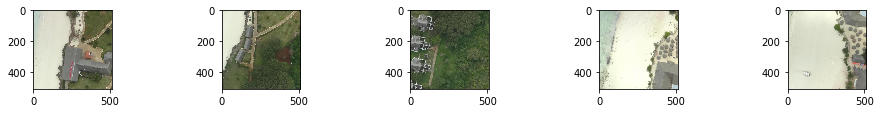

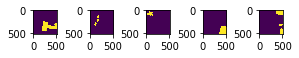

In [5]:
ids= ['train_rgb_1','train_rgb_2','train_rgb_3','train_rgb_4','train_rgb_5']
ids1= ['train_mask_1','train_mask_2','train_mask_3','train_mask_4','train_mask_5']
plt.figure(figsize=(20,20))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name + '.jpg')
    #img_mask = imread(train_path_masks + "/" + img_name + '.jpg')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    #plt.subplot(1,2*(1+len(ids1)),q*2)
    #plt.imshow(img_mask)
plt.show()
for j, img_name in enumerate(ids1):
    q = j+1
    #img = imread(train_path_images + "/" + img_name + '.jpg')
    img_mask = imread(train_path_masks + "/" + img_name + '.jpg')
    
    #plt.subplot(1,2*(1+len(ids)),q*2-1)
    #plt.imshow(img)
    plt.subplot(1,2*(1+len(ids1)),q*2)
    plt.imshow(img_mask)
plt.show()

In [6]:
train_rgb_ids = next(os.walk(train_path_images))[2]
train_mask_ids = next(os.walk(train_path_masks))[2]
test_rgb_ids = next(os.walk(test_path_images))[2]
test_mask_ids = next(os.walk(test_path_masks))[2]


In [67]:
train_rgb_ids = next(os.walk(train_path_images))[2]

StopIteration: 

In [7]:
#Get and resize train images and masks
X_train = np.zeros((len(train_rgb_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_mask_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_rgb_ids), total=len(train_rgb_ids)):
    img = imread(path_train + '/rgb/' + id_)
    x = resize(img, (512, 512, 3), mode='constant', preserve_range=True)
    X_train[n] = x
#     mask = imread(path_train + '/mask/' + id_)
#     Y_train[n] = resize(mask, (512, 512, 1), 
#                         mode='constant', 
#                         preserve_range=True)

print('Done!')
for n, id_ in tqdm_notebook(enumerate(train_mask_ids), total=len(train_mask_ids)):
#     img = imread(path_train + '/rgb/' + id_)
#     x = resize(img, (512, 512, 3), mode='constant', preserve_range=True)
#     X_train[n] = x
    mask = imread(path_train + '/mask/' + id_)
    Y_train[n] = resize(mask, (512, 512, 1), 
                        mode='constant', 
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!



Done!


In [8]:
print(X_train.shape,Y_train.shape)

(200, 512, 512, 3) (200, 512, 512, 1)


In [9]:
print(X_train[0].shape)
print(Y_train[0].shape)

(512, 512, 3)
(512, 512, 1)


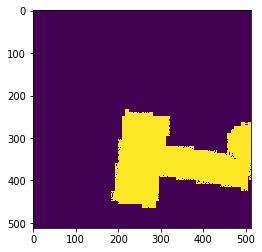

In [10]:
plt.imshow(X_train[0])

tmp = np.squeeze(Y_train[0]).astype(np.float32)
plt.imshow(tmp)

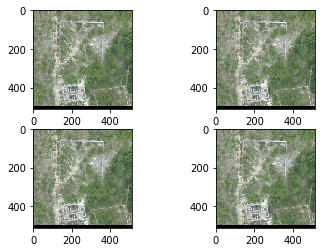

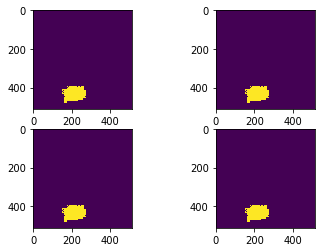

In [11]:
ix = random.randint(0, len(train_rgb_ids))
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(X_train[ix])
axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(X_train[ix])

f, axarr1 = plt.subplots(2,2)
axarr1[0,0].imshow(np.squeeze(Y_train[ix]).astype(np.float32))
axarr1[0,1].imshow(np.squeeze(Y_train[ix]).astype(np.float32))
axarr1[1,0].imshow(np.squeeze(Y_train[ix]).astype(np.float32))
axarr1[1,1].imshow(np.squeeze(Y_train[ix]).astype(np.float32))

TypeError: Invalid dimensions for image data

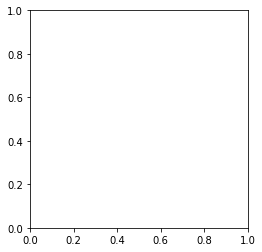

In [12]:
# Check if training data looks all right
ix = random.randint(0, len(train_rgb_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
# tmp = np.squeeze(Y_train[ix]).astype(np.float32)
# plt.imshow(np.dstack((tmp,tmp,tmp)))
# plt.show()

In [13]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [14]:
X_train_shaped = X_train.reshape(-1, 3, 512, 512)/255
Y_train_shaped = Y_train.reshape(-1, 1, 512, 512)

In [15]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

In [16]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [17]:
print(len(X_train_shaped))

200


In [18]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]


In [19]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 2

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [20]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(3, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

In [21]:
model = Unet()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(10):
    tic=time.time()
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.item())
    toc=time.time()-tic
    
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    torch.save(model.state_dict(),"U_NET_3_epochs.pth")
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {} time: {}.'.format(epoch+1, np.mean(train_losses), np.mean(val_losses),toc/60))


Epoch: 1. Train Loss: 0.6477177090115017. Val Loss: 0.6255652248859406 time: 0.41583959658940634.
Epoch: 2. Train Loss: 0.5792414840724733. Val Loss: 0.605215847492218 time: 0.3229867100715637.
Epoch: 3. Train Loss: 0.5557009624110327. Val Loss: 0.6044032454490662 time: 0.3236682017644246.
Epoch: 4. Train Loss: 0.5496340529786216. Val Loss: 0.60480937063694 time: 0.3238344391187032.
Epoch: 5. Train Loss: 0.5403245276874966. Val Loss: 0.602087739109993 time: 0.3152241071065267.
Epoch: 6. Train Loss: 0.5378373232152727. Val Loss: 0.5937479674816132 time: 0.3240837812423706.
Epoch: 7. Train Loss: 0.526841527223587. Val Loss: 0.6060099512338638 time: 0.32644471724828084.
Epoch: 8. Train Loss: 0.522429014245669. Val Loss: 0.6022163599729538 time: 0.32567943731943766.
Epoch: 9. Train Loss: 0.5187658131122589. Val Loss: 0.59476398229599 time: 0.32740869124730426.
Epoch: 10. Train Loss: 0.5172239028745227. Val Loss: 0.6062496453523636 time: 0.32484176953633626.


In [24]:
model.load_state_dict(torch.load("U_NET_3_epochs.pth"))

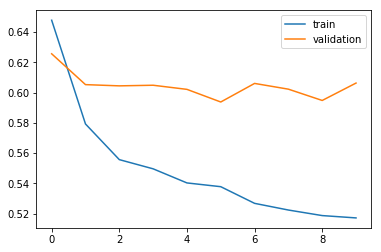

In [25]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

In [26]:
y_pred_true_pairs = []
for images, masks in val_loader:
    images = Variable(images.cuda())
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        #plt.imshow(y_pred)
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))


In [60]:
print(len(y_pred_true_pairs))

20


In [50]:
myarray = np.asarray(y_pred_true_pairs[0][0][0][1])

In [64]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd


In [65]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

TypeError: Invalid dimensions for image data

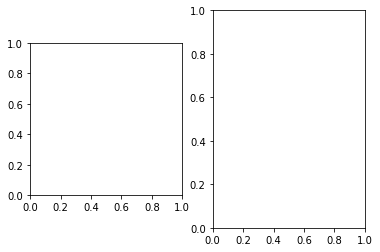

In [66]:
for i in range(5):
    image, mask = y_pred_true_pairs[np.random.randint(0, len(y_pred_true_pairs))]
    plot2x2Array(image, mask)
    

In [ ]:
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

plot_mx_arrays([sample_base, sample_mask])

TypeError: Invalid dimensions for image data

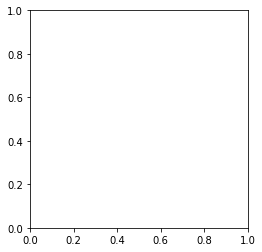

In [39]:
plt.imsho(y_pred_true_pairs[10][0])

In [ ]:
for i, (inputs, labels) in enumerate(dataloaders['test']):

In [63]:
plt.figure(figsize=(20,20))
for (y_pred, mask) in y_pred_true_pairs:
    #mask = np.expand_dims(mask, axis=0)
    plt.imshow(mask)

ValueError: not enough values to unpack (expected 2, got 1)

<Figure size 1440x1440 with 0 Axes>

In [54]:
plt.figure(figsize=(20,20))
for c, y, m in y_pred_true_pairs[0][0]:
    a = np.expand_dims(y, axis=0)
    b = np.expand_dims(m, axis=0)
    plt.imshow(a)
    plt.imshow(b)

ValueError: too many values to unpack (expected 3)

<Figure size 1440x1440 with 0 Axes>

In [58]:
for y_pred, mask in y_pred_true_pairs:
    print(y_pred)
    print('\n')
#     print(mask)

[[[0.30614808 0.32867265 0.28574118 ... 0.22092386 0.2377229  0.22081393]
  [0.26950046 0.27082628 0.2003962  ... 0.14093591 0.18265627 0.17351654]
  [0.2374155  0.23456198 0.16690965 ... 0.12469167 0.15235779 0.18100491]
  ...
  [0.38712546 0.40032908 0.3551596  ... 0.24691567 0.33828306 0.29161412]
  [0.41348922 0.49424902 0.42460838 ... 0.2619646  0.35302833 0.3173541 ]
  [0.338382   0.40045598 0.35494143 ... 0.24732852 0.31198403 0.23720177]]]


[[[0.3690233  0.45652938 0.4701102  ... 0.3054575  0.29538476 0.21329166]
  [0.383698   0.5026179  0.48447013 ... 0.25539222 0.2635458  0.1864558 ]
  [0.3835875  0.5095867  0.48882002 ... 0.2903733  0.2249115  0.17170253]
  ...
  [0.26773024 0.3325216  0.2625209  ... 0.15824485 0.13875094 0.14171757]
  [0.3097158  0.3800514  0.2991812  ... 0.19574916 0.18952411 0.15946645]
  [0.25243485 0.295607   0.240451   ... 0.18953244 0.193037   0.18453692]]]


[[[0.21655324 0.19042583 0.158782   ... 0.27381593 0.23593175 0.19940108]
  [0.1658295  0.14

  [0.3071736  0.33792663 0.26821935 ... 0.39516595 0.43849957 0.2673268 ]]]


[[[0.32020578 0.36387908 0.31166717 ... 0.22192737 0.23684512 0.20302886]
  [0.33675334 0.3460324  0.28376266 ... 0.13557962 0.15491645 0.14353003]
  [0.31720376 0.33482832 0.2682769  ... 0.11591451 0.12793612 0.14356446]
  ...
  [0.35223755 0.34805632 0.2484244  ... 0.13595508 0.16690634 0.1851712 ]
  [0.35845542 0.39013588 0.27661446 ... 0.1678562  0.22791553 0.23165901]
  [0.30551994 0.3169775  0.24659167 ... 0.19717276 0.26223886 0.20185348]]]




In [ ]:
ids= ['train_rgb_1','train_rgb_2','train_rgb_3','train_rgb_4','train_rgb_5']
ids1= ['train_mask_1','train_mask_2','train_mask_3','train_mask_4','train_mask_5']
plt.figure(figsize=(20,20))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name + '.jpg')
    #img_mask = imread(train_path_masks + "/" + img_name + '.jpg')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    #plt.subplot(1,2*(1+len(ids1)),q*2)
    #plt.imshow(img_mask)
plt.show()
for j, img_name in enumerate(ids1):
    q = j+1
    #img = imread(train_path_images + "/" + img_name + '.jpg')
    img_mask = imread(train_path_masks + "/" + img_name + '.jpg')
    
    #plt.subplot(1,2*(1+len(ids)),q*2-1)
    #plt.imshow(img)
    plt.subplot(1,2*(1+len(ids1)),q*2)
    plt.imshow(img_mask)
plt.show()

In [37]:
print(y_pred_true_pairs[1][0][0])

# tmp = np.squeeze(y_pred_true_pairs[0]).astype(np.float32)
# plt.imshow(tmp)

[[0.3690233  0.45652938 0.4701102  ... 0.3054575  0.29538476 0.21329166]
 [0.383698   0.5026179  0.48447013 ... 0.25539222 0.2635458  0.1864558 ]
 [0.3835875  0.5095867  0.48882002 ... 0.2903733  0.2249115  0.17170253]
 ...
 [0.26773024 0.3325216  0.2625209  ... 0.15824485 0.13875094 0.14171757]
 [0.3097158  0.3800514  0.2991812  ... 0.19574916 0.18952411 0.15946645]
 [0.25243485 0.295607   0.240451   ... 0.18953244 0.193037   0.18453692]]


In [26]:
print(len(y_pred_true_pairs))

20


In [32]:
# https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3
for threshold in np.linspace(0, 1, 11):
    
    ious = []
    for y_pred, mask in y_pred_true_pairs:
        prediction = (y_pred > threshold).astype(int)
        iou = jaccard_similarity_score(mask.flatten(), prediction.flatten())
        ious.append(iou)
        
    accuracies = [np.mean(ious > iou_threshold)
                 for iou_threshold in np.linspace(0.5, 0.95, 10)]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))


Threshold: 0.0, Metric: 0.045
Threshold: 0.1, Metric: 0.060
Threshold: 0.2, Metric: 0.220
Threshold: 0.3, Metric: 0.370
Threshold: 0.4, Metric: 0.430
Threshold: 0.5, Metric: 0.460
Threshold: 0.6, Metric: 0.480
Threshold: 0.7, Metric: 0.480
Threshold: 0.8, Metric: 0.480
Threshold: 0.9, Metric: 0.480
Threshold: 1.0, Metric: 0.480


In [35]:
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

plot_mx_arrays([sample_base, sample_mask])

[0.6721343994140625, 0.42589569091796875, 0.40689849853515625, 0.5072135925292969, 0.726470947265625, 0.8286018371582031, 0.5959815979003906, 0.5986175537109375, 0.9892921447753906, 0.9155120849609375, 0.8991203308105469, 0.39905548095703125, 0.7622222900390625, 0.9686393737792969, 0.9620895385742188, 0.8363265991210938, 0.7829437255859375, 0.4168968200683594, 0.8214492797851562, 0.5881690979003906]


TypeError: Invalid dimensions for image data

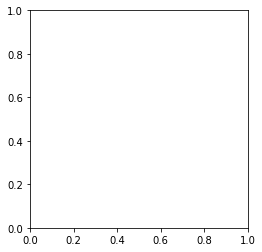

In [34]:
plt.imshow(ious)

# tmp = np.squeeze(ious[0]).astype(np.float32)
# plt.imshow(tmp)